1. Найти ближайшую пару
2. Построить диаграмму Вороного (Форчуна или Разделяй и властвуй)
3. Построить триангуляцию Делоне на основе Вороного

Точки:
(0, 3.5)
(1, 1)
(2, 2)
(2.5, 4)
(3, 0)
(4, 3)
(5, 1.5)

In [7]:
import numpy as np

points = np.array([
    [0, 3.5],
    [1, 1],
    [2, 2],
    [2.5, 4],
    [3, 0],
    [4, 3],
    [5, 1.5]
])

In [8]:
def find_closest_pair(points):
    num_points = len(points)
    min_distance = float('inf')
    closest_pair = None

    for i in range(num_points - 1):
        for j in range(i + 1, num_points):
            distance = np.linalg.norm(points[i] - points[j])
            if distance < min_distance:
                min_distance = distance
                closest_pair = (points[i], points[j])

    print(f"{closest_pair}, {min_distance}")

find_closest_pair(points)

(array([1., 1.]), array([2., 2.])), 1.4142135623730951


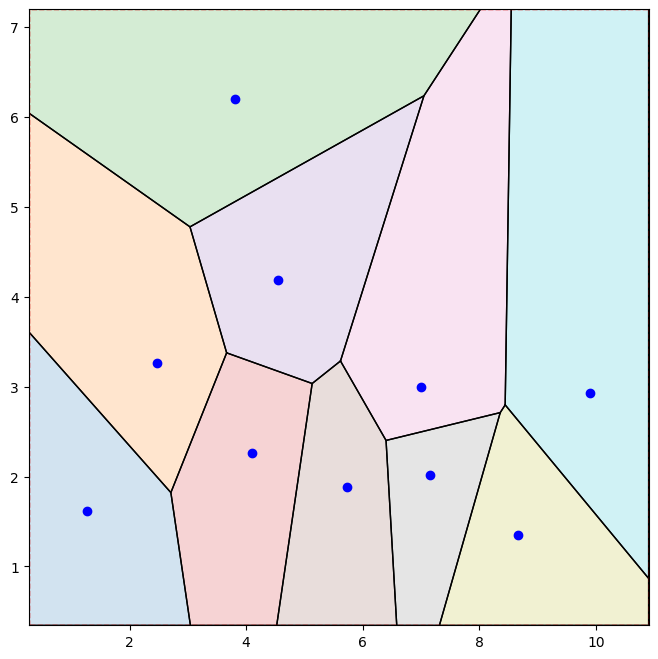

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def bisector(p1, p2):
    mid = (p1 + p2) / 2
    dx, dy = p2 - p1

    A = dx
    B = dy
    C = A * mid[0] + B * mid[1]
    return A, B, C

def line_intersection(A1, B1, C1, A2, B2, C2):
    D = A1*B2 - A2*B1
    if abs(D) < 1e-10:
        return None
    x = (C1*B2 - C2*B1) / D
    y = (A1*C2 - A2*C1) / D
    return np.array([x, y])

def clip_polygon(polygon, A, B, C):
    new_poly = []
    n = len(polygon)
    for i in range(n):
        cur = polygon[i]
        nxt = polygon[(i + 1) % n]
        cur_inside = (A * cur[0] + B * cur[1]) <= C
        nxt_inside = (A * nxt[0] + B * nxt[1]) <= C
        if cur_inside:
            new_poly.append(cur)
        if cur_inside != nxt_inside:
            denom = A * (nxt[0] - cur[0]) + B * (nxt[1] - cur[1])
            if abs(denom) < 1e-10:
                continue
            t = (C - (A * cur[0] + B * cur[1])) / denom
            intersect_point = cur + t * (nxt - cur)
            new_poly.append(intersect_point)
    return np.array(new_poly)

class VoronoiCell:
    def __init__(self, site, polygon):
        self.site = site
        self.polygon = polygon

class VoronoiDiagram:
    def __init__(self, cells):
        self.cells = cells


def voronoi_divide_and_conquer(points, bbox):
    n = len(points)
    if n == 1:
        return VoronoiDiagram([VoronoiCell(points[0], bbox.copy())])
    if n == 2:
        A, B, C = bisector(points[0], points[1])
        cell0 = clip_polygon(bbox.copy(),  A,  B,  C)
        cell1 = clip_polygon(bbox.copy(), -A, -B, -C)
        return VoronoiDiagram([
            VoronoiCell(points[0], cell0),
            VoronoiCell(points[1], cell1)
        ])

    idx = np.argsort(points[:,0])
    points = points[idx]
    mid = n // 2
    left = voronoi_divide_and_conquer(points[:mid], bbox)
    right = voronoi_divide_and_conquer(points[mid:], bbox)

    return merge_voronoi(left, right, bbox)

def merge_voronoi(left, right, bbox):
    all_cells = []

    left_sites = [cell.site for cell in left.cells]
    right_sites = [cell.site for cell in right.cells]

    for cell in left.cells:
        poly = cell.polygon.copy()
        for r in right_sites:
            A, B, C = bisector(cell.site, r)
            # Оставляем полуплоскость, где ближе cell.site
            if (A * r[0] + B * r[1]) < (A * cell.site[0] + B * cell.site[1]):
                A, B, C = -A, -B, -C
            poly = clip_polygon(poly, A, B, C)
            if len(poly) == 0:
                break
        all_cells.append(VoronoiCell(cell.site, poly))

    for cell in right.cells:
        poly = cell.polygon.copy()
        for l in left_sites:
            A, B, C = bisector(cell.site, l)
            if (A * l[0] + B * l[1]) < (A * cell.site[0] + B * cell.site[1]):
                A, B, C = -A, -B, -C
            poly = clip_polygon(poly, A, B, C)
            if len(poly) == 0:
                break
        all_cells.append(VoronoiCell(cell.site, poly))

    return VoronoiDiagram(all_cells)


def plot_voronoi_diagram(diagram, bbox):
    fig, ax = plt.subplots(figsize=(8,8))
    pts = np.array([cell.site for cell in diagram.cells])
    ax.scatter(pts[:,0], pts[:,1], color='blue', zorder=5)
    for cell in diagram.cells:
        poly = cell.polygon
        if len(poly) > 0:
            poly = np.array(poly)
            ax.plot(np.append(poly[:,0], poly[0,0]), np.append(poly[:,1], poly[0,1]), 'k-', lw=1)
            ax.fill(poly[:,0], poly[:,1], alpha=0.2)
    bbox = np.array(bbox)
    ax.plot(np.append(bbox[:,0], bbox[0,0]), np.append(bbox[:,1], bbox[0,1]), 'r--', lw=1)
    ax.set_xlim(np.min(bbox[:,0]), np.max(bbox[:,0]))
    ax.set_ylim(np.min(bbox[:,1]), np.max(bbox[:,1]))
    plt.show()


points = np.random.rand(10, 2) * 10
min_x, min_y = np.min(points, axis=0) - 1
max_x, max_y = np.max(points, axis=0) + 1
bbox = np.array([
    [min_x, min_y],
    [min_x, max_y],
    [max_x, max_y],
    [max_x, min_y]
])
diagram = voronoi_divide_and_conquer(points, bbox)
plot_voronoi_diagram(diagram, bbox)


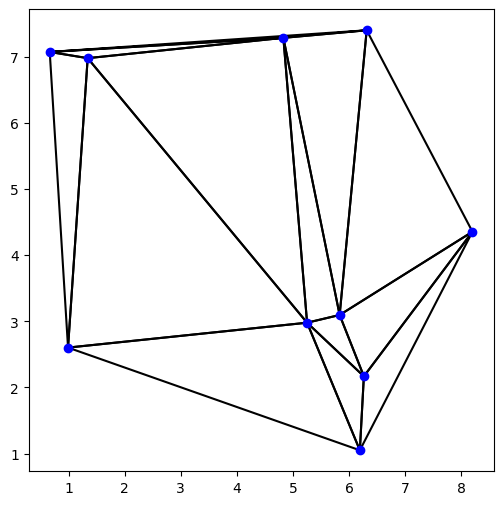

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

def circumcircle(points):
    (x1, y1), (x2, y2), (x3, y3) = points

    d = 2 * (x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))

    ux = ((x1**2 + y1**2)*(y2 - y3) + (x2**2 + y2**2)*(y3 - y1) + (x3**2 + y3**2)*(y1 - y2)) / d
    uy = ((x1**2 + y1**2)*(x3 - x2) + (x2**2 + y2**2)*(x1 - x3) + (x3**2 + y3**2)*(x2 - x1)) / d

    center = np.array([ux, uy])
    radius = sqrt((x1 - ux)**2 + (y1 - uy)**2)
    return center, radius

def is_point_in_circumcircle(point, center, radius):
    return np.linalg.norm(point - center) <= radius + 1e-12

def delaunay(points):
    n = len(points)
    triangles = []

    for i in range(n - 2):
        for j in range(i + 1, n - 1):
            for k in range(j + 1, n):
                center, radius = circumcircle((points[i], points[j], points[k]))
                if center is None:
                    continue

                valid_triangle = True
                for m in range(n):
                    if m == i or m == j or m == k:
                        continue
                    if is_point_in_circumcircle(points[m], center, radius):
                        valid_triangle = False
                        break
                if valid_triangle:
                    triangles.append((i, j, k))

    return triangles

def plot_delaunay(points, triangles):
    plt.figure(figsize=(6,6))
    plt.scatter(points[:,0], points[:,1], color='blue', zorder=5)

    for tri in triangles:
        p1, p2, p3 = points[tri[0]], points[tri[1]], points[tri[2]]
        x_coords = [p1[0], p2[0], p3[0], p1[0]]
        y_coords = [p1[1], p2[1], p3[1], p1[1]]
        plt.plot(x_coords, y_coords, color='black')

    plt.show()

triangles = delaunay(points)
plot_delaunay(points, triangles)


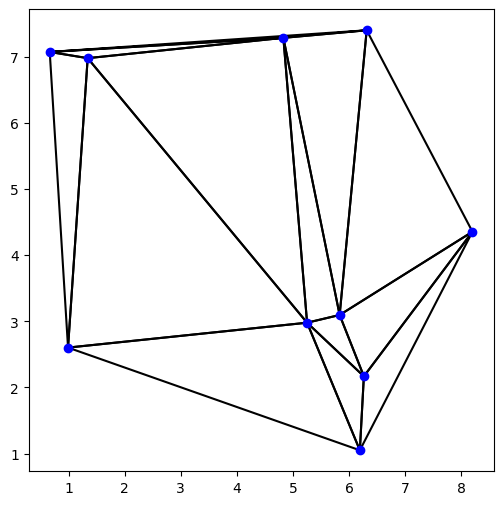

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def delaunay_from_voronoi(diagram):
    site_indices = {tuple(cell.site): i for i, cell in enumerate(diagram.cells)}
    edge_to_sites = defaultdict(set)

    for cell in diagram.cells:
        poly = cell.polygon
        n = len(poly)
        for i in range(n):
            p1 = tuple(np.round(poly[i], 4))
            p2 = tuple(np.round(poly[(i+1)%n], 4))
            edge = frozenset([p1, p2])
            edge_to_sites[edge].add(tuple(cell.site))

    delaunay_edges = set()
    for edge, sites in edge_to_sites.items():
        if len(sites) == 2:
            s1, s2 = list(sites)
            i1 = site_indices[s1]
            i2 = site_indices[s2]
            if i1 != i2:
                delaunay_edges.add(tuple(sorted((i1, i2))))

    return list(delaunay_edges)

def plot_delaunay_from_edges(points, delaunay_edges):
    plt.figure(figsize=(6,6))
    plt.scatter(points[:,0], points[:,1], color='blue', zorder=5)
    for i, j in delaunay_edges:
        p1, p2 = points[i], points[j]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black')
    plt.show()


edges = delaunay_from_voronoi(diagram)
plot_delaunay_from_edges(points, edges)